In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform)               

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=batch_size,
                                         shuffle=False)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def train(net, epochs, trainloader, optimizer, criterion=nn.CrossEntropyLoss(), title="", writer=None):
    print(
        f"training {title} network for {epochs} epochs, {'tensorboard enabled' if writer else 'no tensorboard enabled'}")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_correct += (predicted == labels).sum().item()
            
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 2000))
                if writer:
                    writer.add_scalar(
                        'training loss, ' + title, running_loss/2000, epoch)
                    writer.add_scalar('accuracy, '+title,
                                        running_correct/2000, epoch)

                running_loss = 0.0
                running_correct = 0.0

    print('Finished Training')

In [5]:
# Check accuracy for each class
def validate(net, testloader, batch_size, num_classes, classes):

  class_correct = [0.]*num_classes
  class_total = [0.]*num_classes
  correct = 0
  total = 0

  with torch.no_grad():
    for data in testloader:

      inputs, labels = data[0].to(device), data[1].to(device)
      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)

      #is_correct = (predicted == labels).squeeze()
      is_correct = (predicted == labels)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

     #for i in range(batch_size):
      #    label = labels[i]
      #    class_correct[label] += is_correct[i].item()
      #    class_total[label] += 1
              
 # for i in range(num_classes):
  #  print('Accuracy of %5s : %2d %%' % (
   #       classes[i], 100 * class_correct[i] / class_total[i]))
    
    
  print("total accuracy of net: %.2f%%" % (correct/total*100))


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [10]:
# Prepare a CNN of your choice and train it on the MNIST data.  
# Report the accuracy

training = False
if training:
  net = Net()
  net.to(device)
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  criterion = nn.CrossEntropyLoss()
  train(net, 10, trainloader, optimizer)
else: 
  net = Net()
  net.load_state_dict(torch.load('mnist_10_epochs.pth'))

In [12]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
validate(net, testloader, 100, 10, classes)

total accuracy of net: 95.33%


In [ ]:
if training:
  torch.save(net.state_dict(), 'mnist_10_epochs.pth')

In [16]:
transform = transforms.Compose([
                    transforms.Resize(28),
                    transforms.ToTensor(),
                    transforms.Grayscale(num_output_channels=1),
                    transforms.Normalize((0.1307,), (0.3081,))])
    
trainset_svhn = torchvision.datasets.SVHN(root='./data', 
                                        split='train',
                                        download=True, 
                                        transform=transform)               

trainloader_svhn = torch.utils.data.DataLoader(trainset_svhn, 
                                          batch_size=batch_size,
                                          shuffle=True)

testset_svhn = torchvision.datasets.SVHN(root='./data', 
                                       split='test',
                                       download=True, 
                                       transform=transform)

testloader_svhn = torch.utils.data.DataLoader(testset_svhn, 
                                         batch_size=batch_size,
                                         shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


In [18]:
examples = enumerate(testloader_svhn)
batch_idx, (example_data, example_targets) = next(examples)

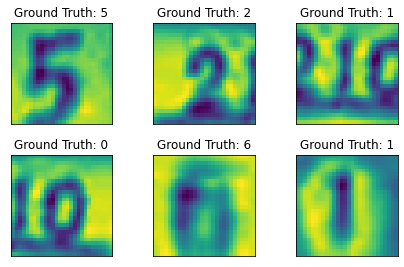

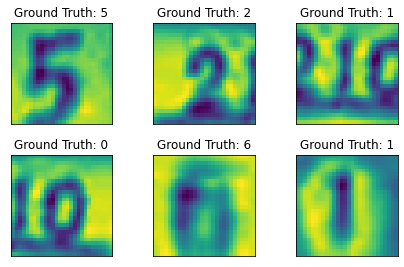

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [20]:
# Use the above model as a pretrained CNN for the SVHN dataset.  
# Report the accuracy
validate(net, testloader_svhn, batch_size, 10, classes)

total accuracy of net: 19.67%


In [22]:
# Perform transfer learning
# Load the model
model = Net()
model.load_state_dict(torch.load('mnist_10_epochs.pth'))
model.to(device)
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
# train the model using SVHN data
train(net = model,
      epochs = 10,
      trainloader = trainloader_svhn,
      optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
      criterion = nn.CrossEntropyLoss()
      )

training  network for 10 epochs, no tensorboard enabled


In [ ]:
validate(net, testloader_svhn, batch_size, 10, classes)

total accuracy of net: 23.75%


In [ ]:
validate(model, testloader, batch_size, 10, classes)